# This notebook contains training step and analysis using nmae result...

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import xgboost as xgb

In [3]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    mae = mean_absolute_error(y_test, y_pred)
    mean_true = np.mean(np.abs(y_test))
    return (mae / mean_true)

def normalized_mean_absolute_error(y_true, y_pred):
    """
    Calculates the Normalized Mean Absolute Error (NMAE).

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        float: The Normalized Mean Absolute Error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate the range of actual values
    y_range = np.max(y_true) - np.min(y_true)

    # Avoid division by zero if the range is zero
    if y_range == 0:
        return 0.0 if mae == 0 else np.inf
    else:
        nmae = mae / y_range
        return nmae

In [4]:
# Load write dataset t100
x_t100 = pd.read_csv('datasets/exp60c_2h/t100/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t100.shape)
x_t100.head(5)

(7803, 1814)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_30,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39
0,1764208944,160047104,24889835520,160047104,21422116864,133148672,23834411008,133148672,21211488256,157319168,...,35801.227711,0,15209.197475,0,39703.165375,0,12482.042834,0,0.0,0.0
1,1764208945,160047104,24889835520,160047104,21422116864,133148672,23834419200,133148672,21211488256,157319168,...,35801.227711,0,15209.197475,0,37991.888760,0,11647.221582,0,0.0,0.0
2,1764208946,160047104,24889835520,160047104,21422116864,133148672,23834419200,133148672,21211488256,157319168,...,40118.899443,0,11010.737086,0,41502.868714,0,9644.138984,0,0.0,0.0
3,1764208947,160047104,24889835520,160047104,21422116864,133148672,23834419200,133148672,21211488256,157319168,...,43221.563228,0,12834.573748,0,30567.436662,0,12157.476523,0,0.0,0.0
4,1764208948,160047104,24889835520,160047104,21422116864,133148672,23834419200,133148672,21211488256,157319168,...,40437.541309,0,10467.878349,0,40874.221669,0,10640.624471,0,0.0,0.0


In [6]:
# Load y t100
y_t100 = pd.read_csv('datasets/exp60c_2h/t100/20251127_020224175_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t100.shape)
y_t100.head(5)

(7803, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
0,1764208944,0,0,0,0,0,0,0.000000,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1764208945,9,0,0,0,4,2,0.059584,0.0,0.0,...,3,10,4.555556,3.086710,3.0,5.333333,10.0,10.0,10.0,10
2,1764208946,17,0,0,0,3,2,0.111808,0.0,0.0,...,2,10,3.625000,2.526526,3.0,3.000000,10.0,10.0,10.0,10
3,1764208947,24,0,0,0,3,2,0.156816,0.0,0.0,...,2,10,3.416667,2.062431,3.0,3.000000,10.0,10.0,10.0,10
4,1764208948,32,0,0,0,3,2,0.207731,0.0,0.0,...,2,10,3.225806,1.856694,3.0,3.000000,10.0,10.0,10.0,10


In [7]:
# Load write dataset t300
x_t300 = pd.read_csv('datasets/exp60c_2h/t300/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t300.shape)
x_t300.head(5)

(7803, 1814)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_30,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39
0,1764246501,160047104,26924138496,160047104,23197761536,133148672,25866366976,133148672,22986809344,157319168,...,35621.542940,0,11630.864765,0,45898.411278,0,11643.953346,0,0.0,0.0
1,1764246502,160047104,26924138496,160047104,23197761536,133148672,25866366976,133148672,22986809344,157319168,...,35621.542940,0,11443.438914,0,41518.031682,0,12333.766656,0,0.0,0.0
2,1764246503,160047104,26924138496,160047104,23197761536,133148672,25866366976,133148672,22986809344,157319168,...,44023.193096,0,12233.075435,0,40220.516171,0,11465.337562,0,0.0,0.0
3,1764246504,160047104,26924138496,160047104,23197761536,133148672,25866407936,133148672,22986850304,157319168,...,44703.338807,0,10793.684660,0,48606.635071,0,12587.396352,0,0.0,0.0
4,1764246505,160047104,26924138496,160047104,23197761536,133148672,25866407936,133148672,22986850304,157319168,...,37078.740157,0,11715.961717,0,41422.115627,0,11544.735240,0,0.0,0.0


In [8]:
# Load y t300
y_t300 = pd.read_csv('datasets/exp60c_2h/t300/20251127_122821246_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t300.shape)
y_t300.head(5)

(7803, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
0,1764246501,0,0,0,0,0,0,0.000000,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0
1,1764246502,9,0,0,0,4,1,0.059584,0.0,0.0,...,3,11,4.888889,3.218868,3.0,6.0,11.00,11.0,11.0,11
2,1764246503,16,0,0,0,4,1,0.105230,0.0,0.0,...,3,11,4.312500,2.468974,3.5,4.0,10.85,11.0,11.0,11
3,1764246504,24,0,0,0,3,1,0.156813,0.0,0.0,...,3,11,4.041667,2.053188,3.5,4.0,10.45,11.0,11.0,11
4,1764246505,31,0,0,0,3,1,0.207727,0.0,0.0,...,3,11,3.838710,1.845658,3.0,4.0,10.10,11.0,11.0,11


In [8]:
# Load write dataset t500
x_t500 = pd.read_csv('datasets/exp90c_2h/t500/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t500.shape)
x_t500.head(5)

(7803, 1814)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_30,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39
0,1764198786,159993856,11839750144,159993856,9786974208,133136384,10936401920,133136384,9330151424,157319168,...,33379.752086,0,10788.920455,0,39880.103694,0,15489.113769,0,0.0,0.000000
1,1764198787,160047104,11839811584,160047104,9787035648,133136384,10936401920,133136384,9330151424,157319168,...,39257.216164,0,12656.750000,0,39880.103694,0,12493.403694,0,0.0,0.000000
2,1764198788,160047104,11839811584,160047104,9787035648,133136384,10936401920,133136384,9330151424,157319168,...,45954.058625,0,11700.878410,0,43284.507786,0,12465.202369,0,0.0,0.000000
3,1764198789,160047104,11839815680,160047104,9787035648,133136384,10936401920,133136384,9330151424,157319168,...,45954.058625,0,12220.613082,0,44117.868676,0,10345.260858,0,0.0,9.389671
4,1764198790,160047104,11839815680,160047104,9787035648,133136384,10936401920,133136384,9330151424,157319168,...,46674.205554,0,9675.200611,0,46040.415380,0,10345.260858,0,0.0,15.648286


In [9]:
# Load y t500
y_t500 = pd.read_csv('datasets/exp90c_2h/t500/20251126_231306003_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t500.shape)
y_t500.head(5)

(7803, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
0,1764198786,0,0,0,0,0,0,0.000000,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1764198787,9,0,0,0,5,2,0.059581,0.0,0.0,...,4,6,5.111111,0.600925,5.0,5.333333,6.0,6.0,6.0,6
2,1764198788,17,0,0,0,4,2,0.111801,0.0,0.0,...,4,6,4.812500,0.655108,5.0,5.000000,6.0,6.0,6.0,6
3,1764198789,24,0,0,0,4,2,0.156806,0.0,0.0,...,4,6,4.625000,0.646899,5.0,5.000000,6.0,6.0,6.0,6
4,1764198790,32,0,0,0,4,2,0.207717,0.0,0.0,...,4,6,4.612903,0.615219,5.0,5.000000,6.0,6.0,6.0,6


# KDE for write dataset metrics

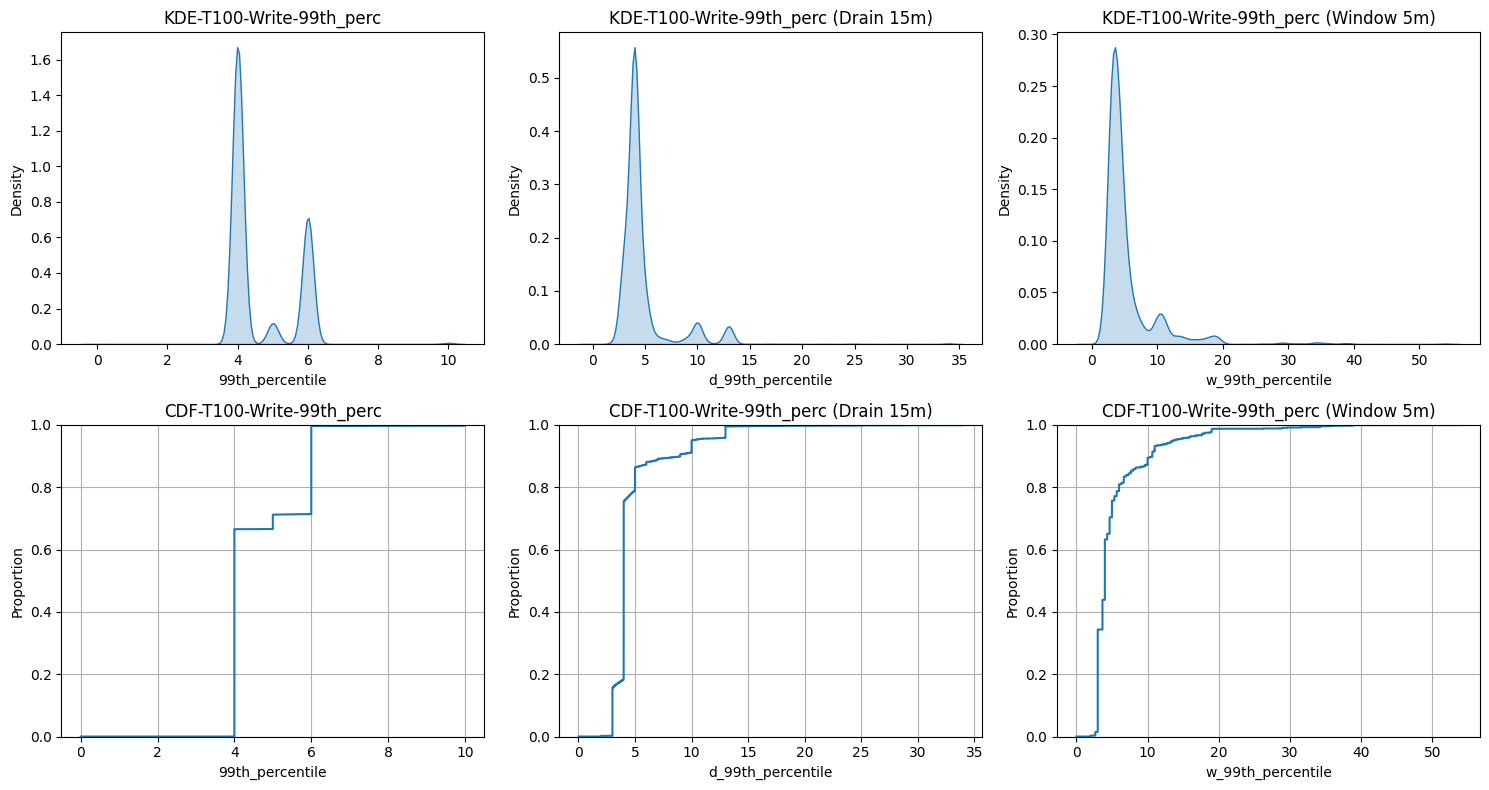

In [9]:
# 99th_percentile t100
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t100['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T100-Write-99th_perc")

sns.kdeplot(y_t100['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T100-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t100['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T100-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t100, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t100, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T100-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t100, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T100-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

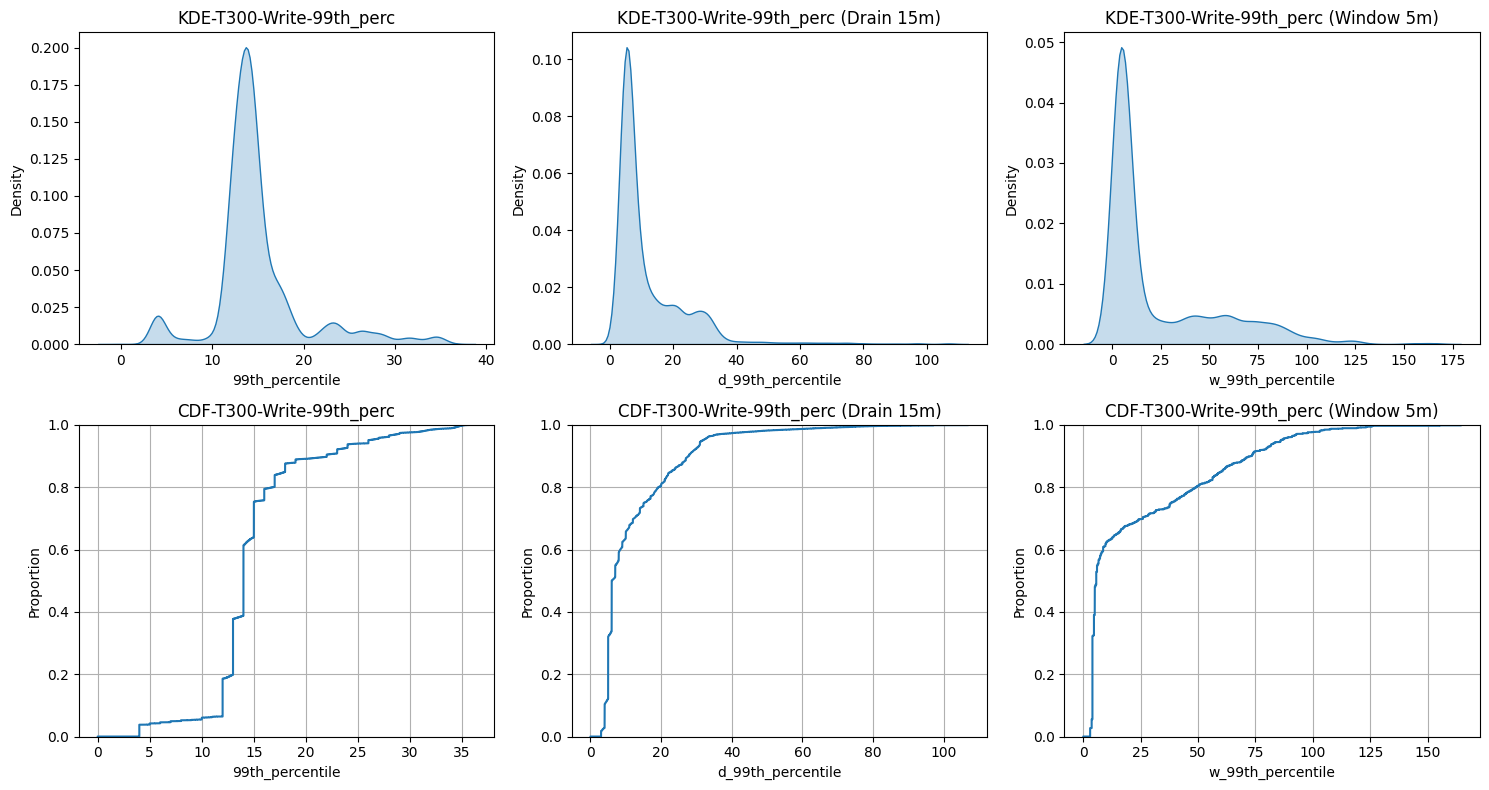

In [10]:
# 99th_percentile t300
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t300['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T300-Write-99th_perc")

sns.kdeplot(y_t300['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T300-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t300['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T300-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t300, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T300-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t300, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T300-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t300, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T300-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

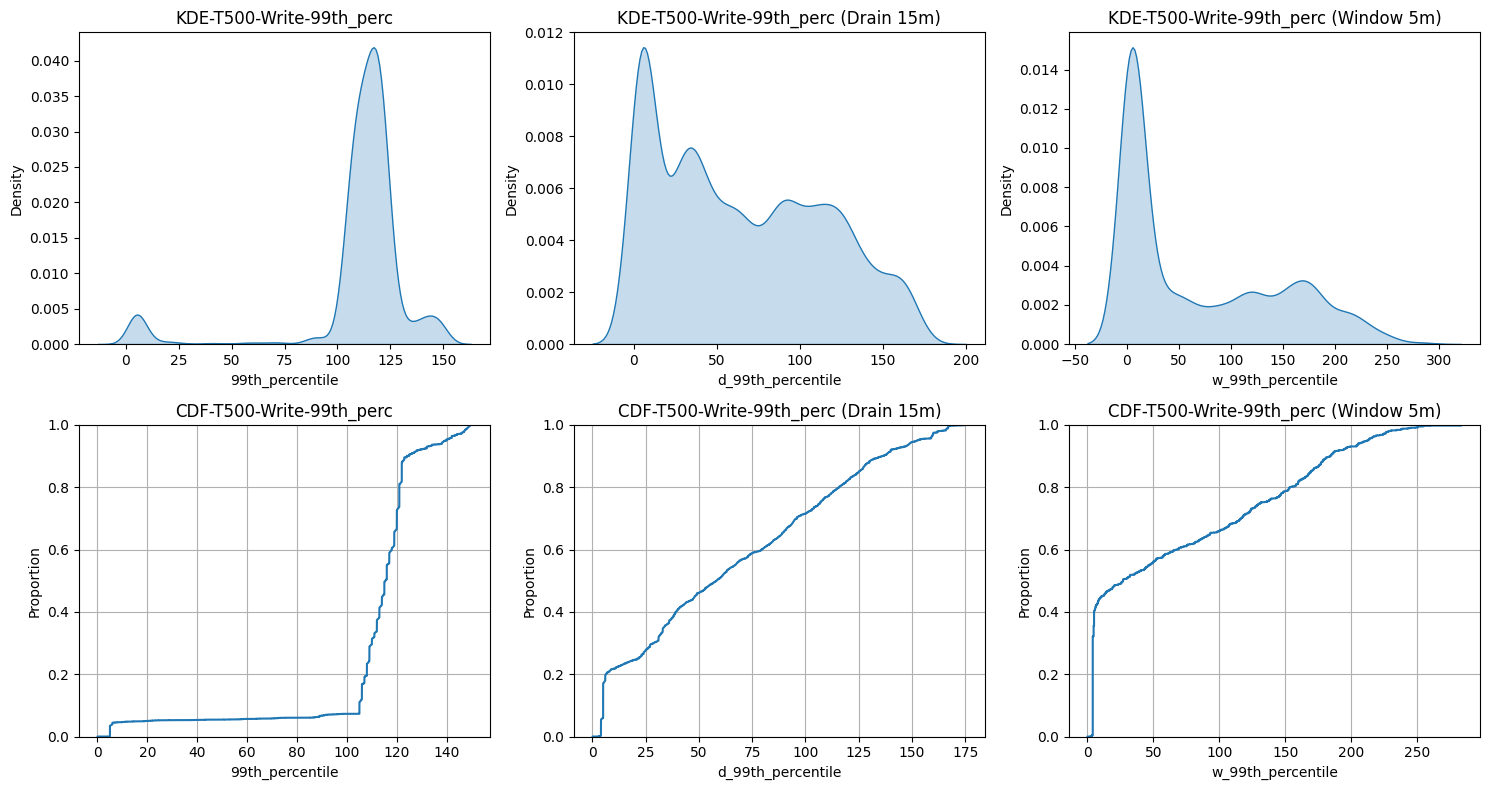

In [16]:
# 99th_percentile t500
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t500['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T500-Write-99th_perc")

sns.kdeplot(y_t500['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T500-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t500['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T500-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t500, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T500-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t500, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T500-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t500, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T500-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [11]:
def get_select_k_best_ds(x, y, k):
    selector = SelectKBest(f_regression, k=k)
    k_best_ds = selector.fit_transform(x, y)

    # Get a boolean mask of selected features
    selected_features_mask = selector.get_support()

    # Get the names of the selected features
    selected_feature_names = x.columns[selected_features_mask]
    print(selected_feature_names)

    k_best_ds = pd.DataFrame(k_best_ds, columns=selected_feature_names, index=x.index)
    print(k_best_ds.shape)
    k_best_ds.head(5)
    return k_best_ds

# Random Forest training using all features and k best features...

## train 70%, test 30%

## T100

In [12]:
# Full dataset - wihout normalization...
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t100, y_t100['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T100 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T100 - Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t100, y_t100['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T100 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T100 - Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t100, y_t100['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T100 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T100 - Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

T100 - Rand. Forest Training time: 8.176872s
T100 - Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.10%
T100 - Rand. Forest Training time: 24.804547s
T100 - Full dataset | d_99th_percentile -> Rand. Forest NMAE: 2.55%
T100 - Rand. Forest Training time: 40.345377s
T100 - Full dataset | w_99th_percentile -> Rand. Forest NMAE: 11.69%


## T300

In [13]:
# Full dataset - wihout normalization...
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t300, y_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T300 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T300 - Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t300, y_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T300 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T300 - Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t300, y_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T300 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T300 - Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

T300 - Rand. Forest Training time: 19.832439s
T300 - Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.33%
T300 - Rand. Forest Training time: 23.524792s
T300 - Full dataset | d_99th_percentile -> Rand. Forest NMAE: 4.38%
T300 - Rand. Forest Training time: 31.822494s
T300 - Full dataset | w_99th_percentile -> Rand. Forest NMAE: 15.63%


## T500

In [19]:
# Full dataset - wihout normalization...
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t500, y_t500['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T500 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T500 - Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t500, y_t500['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T500 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T500 - Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_t500, y_t500['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'T500 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'T500 - Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

T500 - Rand. Forest Training time: 20.975964s
T500 - Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.08%
T500 - Rand. Forest Training time: 23.198372s
T500 - Full dataset | d_99th_percentile -> Rand. Forest NMAE: 1.51%
T500 - Rand. Forest Training time: 35.98412s
T500 - Full dataset | w_99th_percentile -> Rand. Forest NMAE: 5.69%


## Other models...

In [54]:
# Full dataset, using pipeline to normalize features and target.

# Define the feature pipeline
feature_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # Normalize input features
])

rf_regressor = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# Combine with target scaling using TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('preprocess', feature_pipeline),
        ('model', rf_regressor)
    ]),
    transformer=MinMaxScaler()  # Normalizes the target y
)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 30.79498s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.10%
Rand. Forest Training time: 52.514156s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 2.43%
Rand. Forest Training time: 73.947967s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 6.83%


In [55]:
# Full dataset, using xgboost

# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 25.202146s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.09%
Rand. Forest Training time: 59.407267s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 3.09%
Rand. Forest Training time: 69.290943s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 5.87%
